In [2]:
!pip install tensorflow==2.0.0rc0
import tensorflow as tf
print(tf.__version__)

2.0.0-rc0


In [3]:
!wget https://github.com/osaukh/mobile_computing_lab/raw/master/code/OnDeviceActivityRecognition/converter.zip
!unzip converter

--2021-06-17 08:16:32--  https://github.com/osaukh/mobile_computing_lab/raw/master/code/OnDeviceActivityRecognition/converter.zip
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/osaukh/mobile_computing_lab/master/code/OnDeviceActivityRecognition/converter.zip [following]
--2021-06-17 08:16:32--  https://raw.githubusercontent.com/osaukh/mobile_computing_lab/master/code/OnDeviceActivityRecognition/converter.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 61401 (60K) [application/zip]
Saving to: ‘converter.zip.1’

converter.zip.1     100%[===================>]  59.96K  --.-KB/s    in 0.01s   



In [4]:
import sys
sys.path.insert(0,'converter')

from tensorflow.keras.models import Sequential, Model, load_model, save_model
from tensorflow.keras import layers
from tensorflow.keras.regularizers import l2
from tfltransfer import bases
from tfltransfer import heads
from tfltransfer import optimizers
from tfltransfer.tflite_transfer_converter import TFLiteTransferConverter


import os
import shutil
import glob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
!unzip /content/drive/MyDrive/transfer_learning.zip 

Archive:  /content/drive/MyDrive/transfer_learning.zip
replace transfer_learning/running_tf/raw/Running_accel_sensor_data_1623908516432.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: All
  inflating: transfer_learning/running_tf/raw/Running_accel_sensor_data_1623908516432.txt  
  inflating: transfer_learning/running_tf/raw/Running_accel_sensor_data_1623908575882.txt  
  inflating: transfer_learning/running_tf/raw/Running_gyro_sensor_data_1623908516432.txt  
  inflating: transfer_learning/running_tf/raw/Running_gyro_sensor_data_1623908575882.txt  
  inflating: transfer_learning/running_tf/clipped/Running_gyro_sensor_data_1623908575882_original_clipped.npy  
  inflating: transfer_learning/running_tf/clipped/Running_gyro_sensor_data_1623908575882_resampled_clipped.npy  
  inflating: transfer_learning/running_tf/clipped/Running_gyro_sensor_data_1623908575882_original_clipped.csv  
  inflating: transfer_learning/running_tf/clipped/Running_gyro_sensor_data_1623908575882_resampled_clipped.csv  
 

# Load the dataset

In [7]:
data_directory = "transfer_learning"

activities = [
    {"name": "Walking",
     "subdirectory": "walking_tf",
     "label": 0},
    {"name": "Walking Upstairs",
     "subdirectory": "walking_upstairs_tf",
     "label": 1},
    {"name": "Walking Downstairs",
     "subdirectory": "walking_downstairs_tf",
     "label": 2},
     {"name": "Running",
     "subdirectory": "running_tf",
     "label": 3}
     ]

In [8]:
dataset_samples = 0
dataset_label_strings = []
N_activities = 4


for activity in activities:
  subdir = os.path.join(data_directory, activity["subdirectory"], "timeframes")
  N_samples = int(len(os.listdir(subdir)) / 2) # Two files per sample (Accelerometer & Gyroscope)
  dataset_samples += N_samples

print(f"The dataset contains in total {dataset_samples} samples.")

The dataset contains in total 399 samples.


In [9]:
for k in range(N_activities):
  dataset_label_strings.append(activities[k]["name"])
dataset_label_strings

['Walking', 'Walking Upstairs', 'Walking Downstairs', 'Running']

In [10]:
dataset_x = np.zeros((dataset_samples, 200, 6))
dataset_y = np.zeros(dataset_samples, dtype=int)

In [11]:
def sensor_data_normalization(data):
  max_vals = np.abs(data).max(axis=0)
  return data / max_vals
  #return data

In [12]:
sample_idx = 0
for activity in activities:
  name = activity["name"]
  subdirectory = os.path.join(data_directory, activity["subdirectory"])
  label = int(activity["label"])

  gyro_filenames = glob.glob(os.path.join(subdirectory, "timeframes", "*_gyro_sensor_data_*.npy"))
  for gyro_file in gyro_filenames:
    print("Loading {:6d} from {:6d}".format(sample_idx, dataset_samples))
    accel_file = gyro_file.replace("gyro", "accel")

    gyro_data = np.load(os.path.join(gyro_file), allow_pickle=True)
    accel_data = np.load(os.path.join(accel_file), allow_pickle=True)

    gyro_data_normalized = sensor_data_normalization(gyro_data[:,1:])
    accel_data_normalized = sensor_data_normalization(accel_data[:,1:])

    dataset_x[sample_idx, :, 0:3] = gyro_data_normalized
    dataset_x[sample_idx, :, 3:6] = accel_data_normalized

    dataset_y[sample_idx] = label
    sample_idx += 1

Loading      0 from    399
Loading      1 from    399
Loading      2 from    399
Loading      3 from    399
Loading      4 from    399
Loading      5 from    399
Loading      6 from    399
Loading      7 from    399
Loading      8 from    399
Loading      9 from    399
Loading     10 from    399
Loading     11 from    399
Loading     12 from    399
Loading     13 from    399
Loading     14 from    399
Loading     15 from    399
Loading     16 from    399
Loading     17 from    399
Loading     18 from    399
Loading     19 from    399
Loading     20 from    399
Loading     21 from    399
Loading     22 from    399
Loading     23 from    399
Loading     24 from    399
Loading     25 from    399
Loading     26 from    399
Loading     27 from    399
Loading     28 from    399
Loading     29 from    399
Loading     30 from    399
Loading     31 from    399
Loading     32 from    399
Loading     33 from    399
Loading     34 from    399
Loading     35 from    399
Loading     36 from    399
L

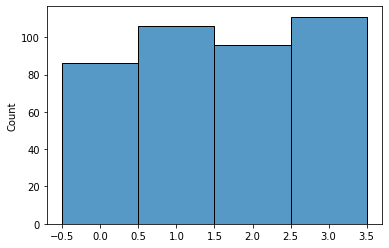

In [13]:
sns.histplot(data=dataset_y, stat="count", discrete=True, bins=N_activities)

(10, 200, 6)
(10, 200, 6)
(10, 200, 6)
(10, 200, 6)


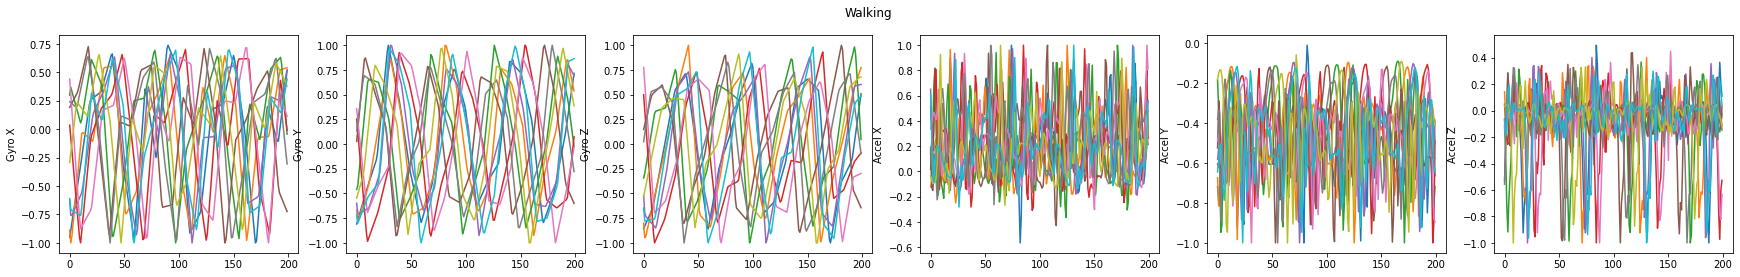

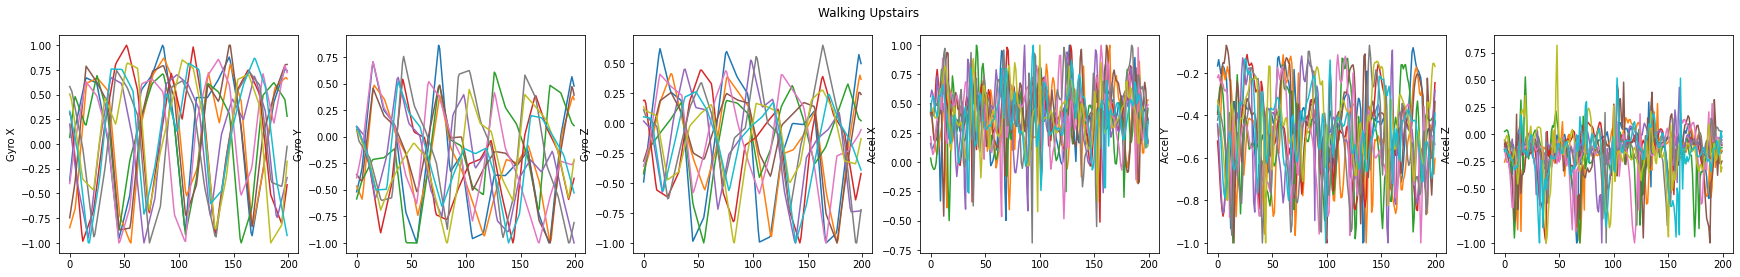

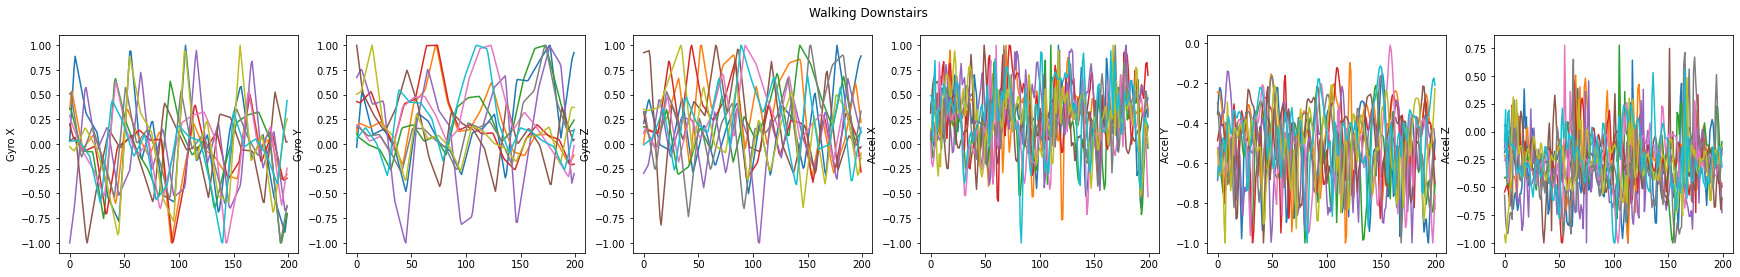

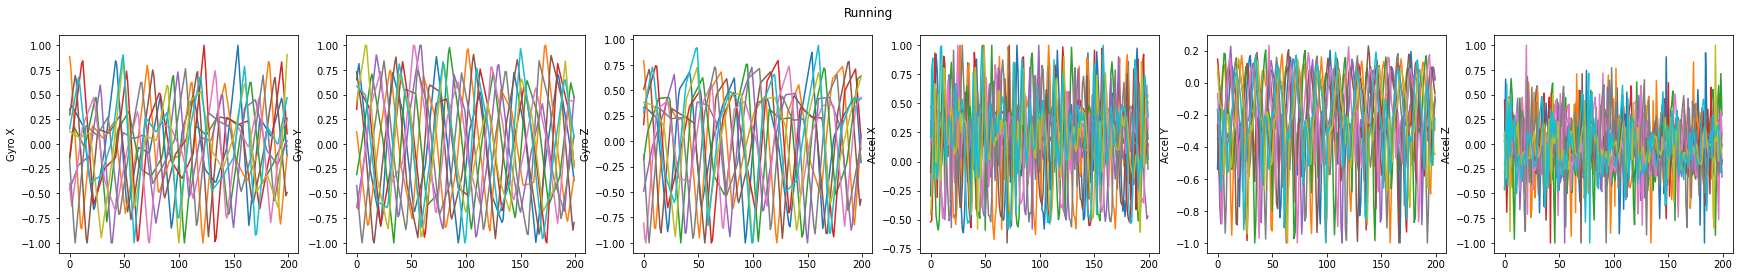

In [14]:
def plot_activity(activity, data):
    fig, (ax0, ax1, ax2, ax3, ax4, ax5) = plt.subplots(ncols=6,
         figsize=(30, 4),
         sharex=True)
    
    x = np.arange(data.shape[0])
    plot_axis(ax0, x, data[:,0], 'Gyroscope, x-Axis')
    plot_axis(ax1, x, data[:,1], 'Gyroscope, y-Axis')
    plot_axis(ax2, x, data[:,2], 'Gyroscope, z-axis')
    plot_axis(ax3, x, data[:,3], 'Accelerometer, x-Axis')
    plot_axis(ax4, x, data[:,4], 'Accelerometer, y-Axis')
    plot_axis(ax5, x, data[:,5], 'Accelerometer, z-axis')
    plt.subplots_adjust(hspace=0.2)
    fig.suptitle(LABELS[activity-1])
    plt.subplots_adjust(top=0.8)
    plt.show()


def plot_activity(data, axes):
  print(data.shape)
  x = np.arange(data.shape[1])
  for l in range(len(axes)):
    ax = axes[l]
    for k in range(data.shape[0]):
      ax.plot(x, data[k,:,l], label="{:d}".format(k))



for activity in activities:
  label = activity["label"]
  idx = np.where(dataset_y == label)[0]

  fig, (ax0, ax1, ax2, ax3, ax4, ax5) = plt.subplots(ncols=6,
         figsize=(30, 4),
         sharex=True)
  
  plot_activity(dataset_x[idx[:10], :, :], [ax0, ax1, ax2, ax3, ax4, ax5])
  
  ax0.set_ylabel("Gyro X")
  ax1.set_ylabel("Gyro Y")
  ax2.set_ylabel("Gyro Z")
  ax3.set_ylabel("Accel X")
  ax4.set_ylabel("Accel Y")
  ax5.set_ylabel("Accel Z")
  fig.suptitle(activity["name"])

In [15]:
from tensorflow.keras.utils import to_categorical
dataset_y_hot = to_categorical(dataset_y, num_classes=N_activities)
print('New dataset_y shape: ', dataset_y_hot.shape)

New dataset_y shape:  (399, 4)


In [16]:
from numpy.random import default_rng
rng = default_rng(seed=1234) # Use seed for reproducability

VALIDATION_SPLIT = 0.25

N_validation_samples = int(np.floor(dataset_samples * VALIDATION_SPLIT))
N_training_samples = dataset_samples - N_validation_samples

validation_set_indices = np.zeros((N_validation_samples), dtype=int)
# Get N_validation_samples unique indices for the validation set
for k in range(N_validation_samples):
  idx_tmp = rng.integers(low=0, high=dataset_samples - 1, size=1)
  while idx_tmp in validation_set_indices:
    idx_tmp = rng.integers(low=0, high=dataset_samples - 1, size=1)
  validation_set_indices[k] = idx_tmp

validation_set_boolean_indices = np.zeros(dataset_samples, dtype=bool)
validation_set_boolean_indices[validation_set_indices] = True
training_set_boolean_indices = ~validation_set_boolean_indices


x_train = dataset_x[training_set_boolean_indices, :]
y_train = dataset_y[training_set_boolean_indices]
y_train_hot = dataset_y_hot[training_set_boolean_indices, :]

x_validate = dataset_x[validation_set_boolean_indices, :]
y_validate = dataset_y[validation_set_boolean_indices]
y_validate_hot = dataset_y_hot[validation_set_boolean_indices, :]

In [17]:
tmp = validation_set_indices.sort()
validation_set_indices

array([  1,   3,  16,  18,  23,  34,  36,  41,  43,  47,  55,  61,  64,
        67,  68,  70,  71,  72,  76,  79,  88,  90,  96, 100, 101, 104,
       110, 111, 121, 126, 127, 131, 140, 142, 147, 151, 160, 169, 171,
       174, 175, 178, 180, 186, 187, 192, 206, 211, 213, 218, 221, 231,
       242, 243, 257, 261, 262, 267, 268, 269, 272, 278, 291, 292, 293,
       298, 299, 301, 302, 303, 308, 312, 313, 315, 316, 319, 329, 335,
       339, 341, 343, 344, 345, 346, 349, 357, 360, 366, 367, 374, 377,
       380, 381, 383, 388, 389, 391, 393, 394])

# Create, train and test the transfer-learnin model on the previously loaded dataset

In [18]:
import os
import re

import numpy as np
import pandas as pd
from scipy import stats
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import preprocessing

from matplotlib import pyplot as plt

In [19]:
# Load base model and fix its weights
base_model = load_model('/content/drive/MyDrive/MCL/WS04/base_model.pbtxt')
print(base_model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 200, 6, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 191, 3, 4)         164       
_________________________________________________________________
dropout (Dropout)            (None, 191, 3, 4)         0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 19, 3, 4)          0         
_________________________________________________________________
headlayer (Flatten)          (None, 228)               0         
_________________________________________________________________
dense (Dense)                (None, 8192)              1875968   
_________________________________________________________________
dropout_1 (Dropout)          (None, 8192)              0

In [20]:
chopped_model = Model(base_model.input, base_model.get_layer('headlayer').output)
chopped_model.trainable = False
print(chopped_model.summary())

chopped_model.save('/content/drive/MyDrive/MCL/WS04/chopped_model.pbtxt', include_optimizer = False, save_format="tf")

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_input (InputLayer)   [(None, 1200)]            0         
_________________________________________________________________
reshape (Reshape)            (None, 200, 6, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 191, 3, 4)         164       
_________________________________________________________________
dropout (Dropout)            (None, 191, 3, 4)         0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 19, 3, 4)          0         
_________________________________________________________________
headlayer (Flatten)          (None, 228)               0         
Total params: 164
Trainable params: 0
Non-trainable params: 164
_______________________________________________________________

In [21]:
# New head configuration
num_classes = len(activities)
learning_rate = 0.001
l2_rate = 0.0001
input_shape = base_model.get_layer('headlayer').output.shape

head_model = tf.keras.Sequential()
head_model.add(layers.Dense(2048, activation="relu", input_shape = (input_shape[1],), use_bias=True))
head_model.add(layers.Dropout(0.1))
head_model.add(layers.Dense(1024, activation="relu", use_bias=True))
head_model.add(layers.Dense(num_classes, activation='softmax', use_bias=True))
print(head_model.summary())

head_model.compile(loss="categorical_crossentropy", optimizer="adam")


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 2048)              468992    
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 4100      
Total params: 2,571,268
Trainable params: 2,571,268
Non-trainable params: 0
_________________________________________________________________
None


In [22]:
base_model.get_layer('headlayer')

In [23]:
# The weights of the base model should be fixes
chopped_model.trainable=False

# Combine chopped model (with untrainiable weights) and head model (with trainiable weights)
tf_learning_model = Sequential()
tf_learning_model.add(chopped_model)
tf_learning_model.add(head_model)

print(tf_learning_model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Model)                (None, 228)               164       
_________________________________________________________________
sequential (Sequential)      (None, 4)                 2571268   
Total params: 2,571,432
Trainable params: 2,571,268
Non-trainable params: 164
_________________________________________________________________
None


In [24]:
tf_learning_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [25]:
x_train_reshaped = x_train.reshape(x_train.shape[0],1200)
x_validate_reshaped = x_validate.reshape(x_validate.shape[0], 1200)

In [26]:
tf_learning_model.input_shape

(None, 1200)

# Export model to TFLite

In [35]:
base = bases.SavedModelBase('/content/drive/MyDrive/MCL/WS04/chopped_model.pbtxt')
batch_size = 10

converter = TFLiteTransferConverter(num_classes,
                base,
                heads.KerasModelHead(head_model),
                optimizers.SGD(l2_rate),
                train_batch_size=batch_size)

converter.convert_and_save('/content/drive/MyDrive/MCL/WS04/custom_keras_model_SGD')

converter = TFLiteTransferConverter(num_classes,
                base,
                heads.KerasModelHead(head_model),
                optimizers.Adam(),
                train_batch_size=batch_size)

converter.convert_and_save('/content/drive/MyDrive/MCL/WS04/custom_keras_model_Adam')

dir = "/content/drive/MyDrive/MCL/WS04/transfer_learning_device_dataset"
training_set_dir = dir + "/training_set"
test_set_dir = dir + "/test_set"
if os.path.isdir(dir):
  shutil.rmtree(dir)
os.mkdir(dir)
os.mkdir(training_set_dir)
os.mkdir(test_set_dir)

for k in range(x_train.shape[0]):
  filename = training_set_dir + "/sample_{:d}_activity_{:d}.csv".format(k, y_train[k])
  #print("Writing \"{:s}\"".format(filename))
  np.savetxt(filename, x_train[k,:,:], delimiter=";")

for k in range(x_validate.shape[0]):
  filename = test_set_dir + "/sample_{:d}_activity_{:d}.csv".format(k, y_validate[k])
  #print("Writing \"{:s}\"".format(filename))
  np.savetxt(filename, x_validate[k,:,:], delimiter=";")

INFO:tensorflow:Signatures INCLUDED in export for Classify: None
INFO:tensorflow:Signatures INCLUDED in export for Regress: None
INFO:tensorflow:Signatures INCLUDED in export for Predict: None
INFO:tensorflow:Signatures INCLUDED in export for Train: ['train']
INFO:tensorflow:Signatures INCLUDED in export for Eval: None
INFO:tensorflow:No assets to save.
INFO:tensorflow:No assets to write.
INFO:tensorflow:Signatures INCLUDED in export for Classify: None
INFO:tensorflow:Signatures INCLUDED in export for Regress: None
INFO:tensorflow:Signatures INCLUDED in export for Predict: None
INFO:tensorflow:Signatures INCLUDED in export for Train: None
INFO:tensorflow:Signatures INCLUDED in export for Eval: ['eval']
INFO:tensorflow:No assets to save.
INFO:tensorflow:No assets to write.
INFO:tensorflow:Signatures INCLUDED in export for Classify: None
INFO:tensorflow:Signatures INCLUDED in export for Regress: None
INFO:tensorflow:Signatures INCLUDED in export for Predict: ['serving_default']
INFO:tens

/usr/local/lib/python3.7/dist-packages/tensorflow_core/lite/python/lite.py:854: UserWarning: Property target_ops is deprecated, please use target_spec.supported_ops instead.
  "target_spec.supported_ops instead." % name)


INFO:tensorflow:Signatures INCLUDED in export for Classify: None
INFO:tensorflow:Signatures INCLUDED in export for Regress: None
INFO:tensorflow:Signatures INCLUDED in export for Predict: None
INFO:tensorflow:Signatures INCLUDED in export for Train: ['train']
INFO:tensorflow:Signatures INCLUDED in export for Eval: None
INFO:tensorflow:No assets to save.
INFO:tensorflow:No assets to write.
INFO:tensorflow:Signatures INCLUDED in export for Classify: None
INFO:tensorflow:Signatures INCLUDED in export for Regress: None
INFO:tensorflow:Signatures INCLUDED in export for Predict: None
INFO:tensorflow:Signatures INCLUDED in export for Train: None
INFO:tensorflow:Signatures INCLUDED in export for Eval: ['eval']
INFO:tensorflow:No assets to save.
INFO:tensorflow:No assets to write.
INFO:tensorflow:Signatures INCLUDED in export for Classify: None
INFO:tensorflow:Signatures INCLUDED in export for Regress: None
INFO:tensorflow:Signatures INCLUDED in export for Predict: ['serving_default']
INFO:tens

/usr/local/lib/python3.7/dist-packages/tensorflow_core/lite/python/lite.py:854: UserWarning: Property target_ops is deprecated, please use target_spec.supported_ops instead.
  "target_spec.supported_ops instead." % name)


# For Validation: Tarain and Test model offline

In [28]:
# Hyper-parameters
BATCH_SIZE = 10
EPOCHS = 10

# Enable validation to use ModelCheckpoint and EarlyStopping callbacks.
history = tf_learning_model.fit(x_train_reshaped, y_train_hot, batch_size=BATCH_SIZE, epochs=EPOCHS,
                      validation_split=0.2, verbose=1)

Train on 240 samples, validate on 60 samples
Epoch 1/10
240/240 [==============================] - 2s 7ms/sample - loss: 0.7074 - accuracy: 0.7375 - val_loss: 1.0127 - val_accuracy: 0.4667
Epoch 2/10
240/240 [==============================] - 1s 4ms/sample - loss: 0.1309 - accuracy: 0.9708 - val_loss: 0.2421 - val_accuracy: 1.0000
Epoch 3/10
240/240 [==============================] - 1s 4ms/sample - loss: 0.0188 - accuracy: 0.9958 - val_loss: 0.1037 - val_accuracy: 0.9833
Epoch 4/10
240/240 [==============================] - 1s 4ms/sample - loss: 0.0107 - accuracy: 1.0000 - val_loss: 0.0240 - val_accuracy: 1.0000
Epoch 5/10
240/240 [==============================] - 1s 3ms/sample - loss: 0.0021 - accuracy: 1.0000 - val_loss: 0.0163 - val_accuracy: 1.0000
Epoch 6/10
240/240 [==============================] - 1s 3ms/sample - loss: 7.4295e-04 - accuracy: 1.0000 - val_loss: 0.0132 - val_accuracy: 1.0000
Epoch 7/10
240/240 [==============================] - 1s 3ms/sample - loss: 6.9267e-04 

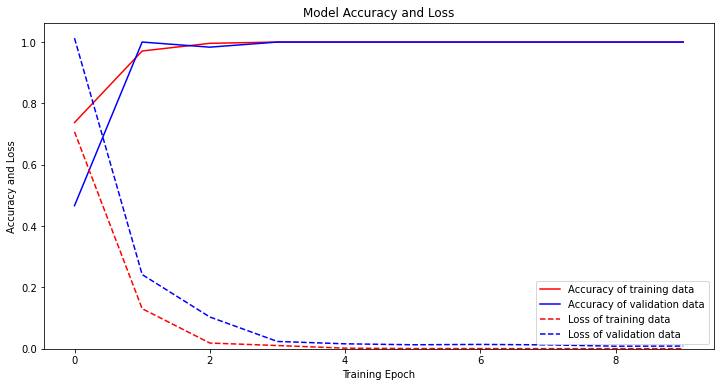

In [29]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], 'r', label='Accuracy of training data')
plt.plot(history.history['val_accuracy'], 'b', label='Accuracy of validation data')
plt.plot(history.history['loss'], 'r--', label='Loss of training data')
plt.plot(history.history['val_loss'], 'b--', label='Loss of validation data')
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()

In [30]:
score = tf_learning_model.evaluate(x_validate_reshaped, y_validate_hot, verbose=0)

print('\nAccuracy on test data: %0.2f' % score[1])
print('\nLoss on test data: %0.2f' % score[0])


Accuracy on test data: 1.00

Loss on test data: 0.01


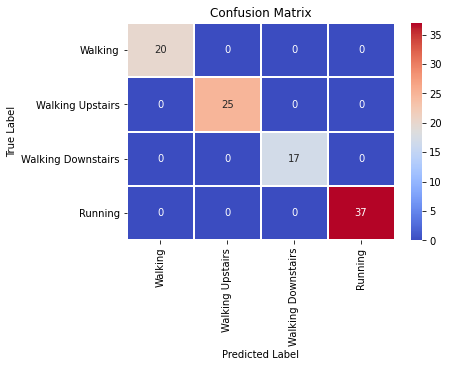

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       1.00      1.00      1.00        25
           2       1.00      1.00      1.00        17
           3       1.00      1.00      1.00        37

    accuracy                           1.00        99
   macro avg       1.00      1.00      1.00        99
weighted avg       1.00      1.00      1.00        99



In [31]:
import seaborn as sns

def show_confusion_matrix(validations, predictions):

    matrix = metrics.confusion_matrix(validations, predictions)
    plt.figure(figsize=(6, 4))
    sns.heatmap(matrix,
                cmap='coolwarm',
                linecolor='white',
                linewidths=1,
                xticklabels=dataset_label_strings,
                yticklabels=dataset_label_strings,
                annot=True,
                fmt='d')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

y_pred_validate = tf_learning_model.predict(x_validate_reshaped)
# Take the class with the highest probability from the test predictions
max_y_pred_validate = np.argmax(y_pred_validate, axis=1)
max_y_validate = np.argmax(y_validate_hot, axis=1)

show_confusion_matrix(max_y_validate, max_y_pred_validate)

print(classification_report(max_y_validate, max_y_pred_validate))

In [32]:
x_train.shape

(300, 200, 6)

In [33]:
x_validate.shape

(99, 200, 6)